# **Homework 8 - Anomaly Detection**

If there are any questions, please contact ntu-ml-2021spring-ta@googlegroups.com

# Mounting your gdrive (Optional)
By mounting your gdrive, you can save and manage your data and models in your Google drive

## Package installation

## Downloading data
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/15XWO-zI-AKW0igfwSydmwSGa8ENb9wCg

In [ ]:

!gdown --id '1q46gQF-OWji_2D9sehUOcZeAjeWQN0Wq' --output data-bin.tar.gz 



Downloading...
From: https://drive.google.com/uc?id=1q46gQF-OWji_2D9sehUOcZeAjeWQN0Wq
To: /content/data-bin.tar.gz
1.64GB [00:15, 108MB/s]


## Untar data

data-bin contains 2 files
```
data-bin/
├── trainingset.npy
├── testingset.npy
...
```

In [ ]:
!tar zxvf data-bin.tar.gz
!ls data-bin
!ls data-bin
!rm data-bin.tar.gz

data-bin/
data-bin/testingset.npy
data-bin/trainingset.npy
testingset.npy	trainingset.npy
testingset.npy	trainingset.npy


# Import packages

In [ ]:
# Training progress bar
!pip install -q qqdm

from qqdm.notebook import qqdm

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW


from random import randint
import pandas as pd
from torch import Tensor

# Loading data

In [ ]:

train_ = np.load('data-bin/trainingset.npy', allow_pickle=True)
test = np.load('data-bin/testingset.npy', allow_pickle=True)
train_ = train_[:-1]
print(train_.shape)
print(test.shape)

(140000, 64, 64, 3)
(19999, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(19530615)

# Autoencoder

# Models & loss

Lecture video：https://www.youtube.com/watch?v=6W8FqUGYyDo&list=PLJV_el3uVTsOK_ZK5L0Iv_EQoL1JefRL4&index=8

fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner

conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),        
            nn.ReLU(), 
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),        
            nn.ReLU(),
            
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),         
            nn.ReLU(),
            
            # nn.Conv2d(48, 96, 4, stride=2, padding=1),   # medium: remove this layer
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        #print('Decoder ouptut size',x.shape)
        return x



class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), # medium: remove this layer
            # nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24), 
            nn.ReLU(),
            
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
             
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
    def forward(self,x):
        x = self.decoder(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 12, 3, stride=2),
            nn.BatchNorm2d(12),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(12, 24, 3, stride=2),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(24, 48, 3, stride=2),
            nn.BatchNorm2d(48),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(48, 96, 3, stride=2),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(0.2, inplace=True),

        )
        self.adv_layer = nn.Sequential(
            nn.Linear(96 * 3 * 3, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [ ]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self ,tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
                            transforms.Lambda(lambda x: x.to(torch.float32)),
                            transforms.Lambda(lambda x: 2. * x/255. - 1.),
                            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        size = x.shape[1]

        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        #n = np.random.normal(0, 0.2, (size,size))
        #n = torch.from_numpy(n).float()
        #x_noise = (x + n).clamp(-1.0, 1.0)

        return x #, x_noise

    def __len__(self):
        return len(self.tensors)

# Training

## Initialize
- hyperparameters
- dataloader
- model
- optimizer & loss


In [ ]:
# Training hyperparameters
num_epochs = 50
batch_size = 1000 # medium: smaller batchsize
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train_)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
enc = Encoder().cuda()
dec = Decoder().cuda()
c = Discriminator().cuda()

# Loss and optimizer
criterion_mse = nn.MSELoss()
criterion_b = nn.BCELoss() 
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=learning_rate , weight_decay=0.00001)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=learning_rate , weight_decay=0.00001)
optimizer_c = torch.optim.Adam(c.parameters(), lr=learning_rate , weight_decay=0.00001)

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:36<00:00:00  3.84it/s    1     0.0315      0.0007               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


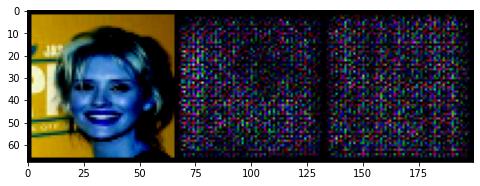

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


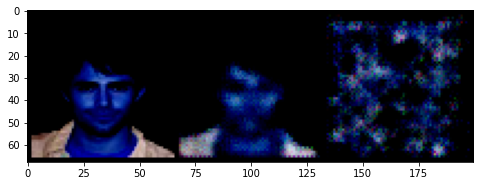

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:36<00:00:00  3.85it/s    2     0.0213      0.0006               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


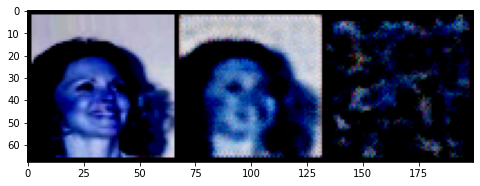

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:36<00:00:00  3.80it/s    3     0.0165      0.0005               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


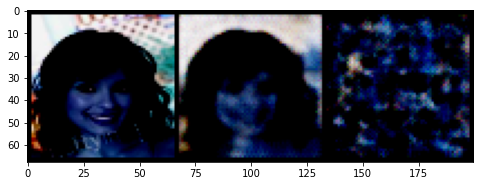

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


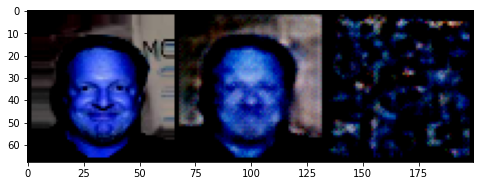

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:36<00:00:00  3.80it/s    4     0.0136      0.0006               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


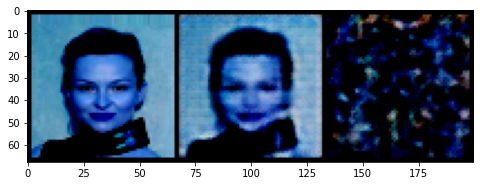

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:37<00:00:00  3.75it/s    5     0.0121      0.0002               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


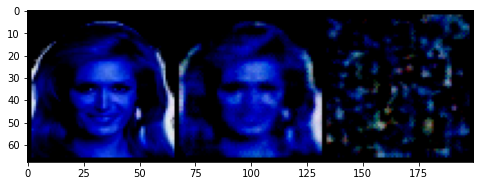

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:37<00:00:00  3.73it/s    6     0.0109      0.0002               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


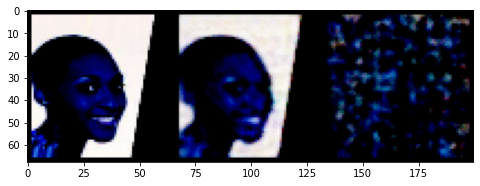

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


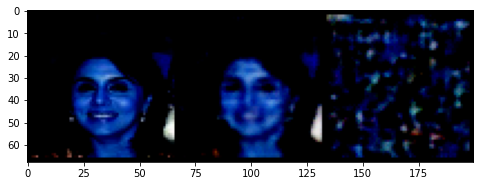

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:37<00:00:00  3.74it/s    7      0.01       0.0002               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


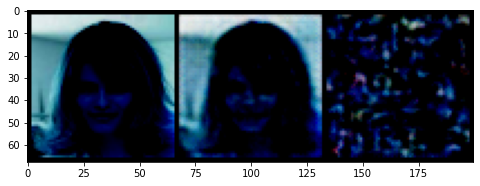

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:37<00:00:00  3.70it/s    8     0.0091      0.0001               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


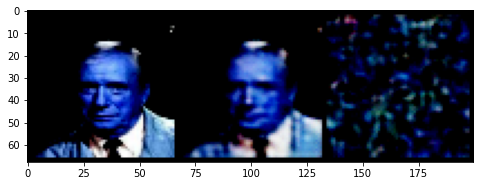

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


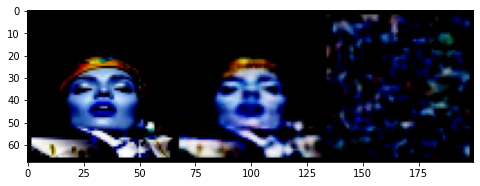

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:37<00:00:00  3.71it/s    9     0.0086      0.0001               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


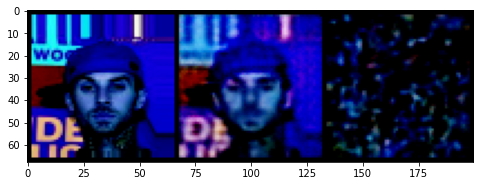

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:38<00:00:00  3.68it/s   10     0.0084      0.0001               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


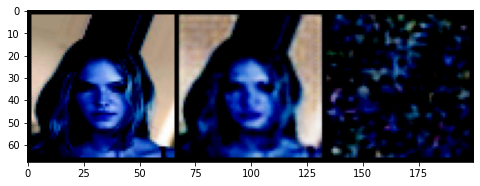

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:38<00:00:00  3.68it/s   11     0.0086       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


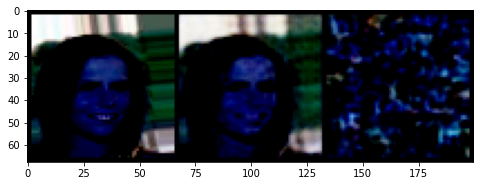

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


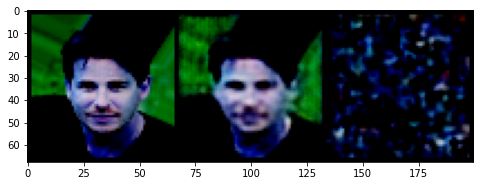

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:38<00:00:00  3.64it/s   12     0.0076      0.0001               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


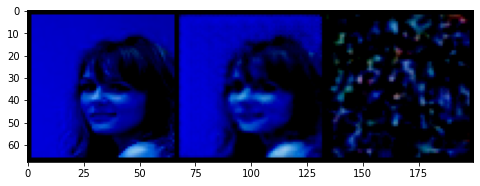

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:38<00:00:00  3.63it/s   13     0.0074       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


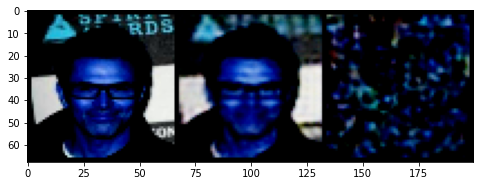

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


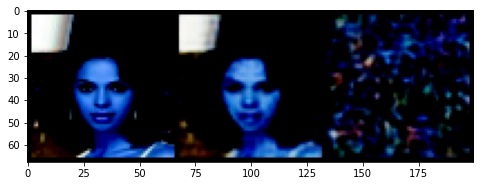

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:38<00:00:00  3.62it/s   14     0.0072      0.0001               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


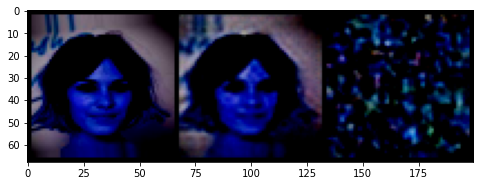

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:39<00:00:00  3.58it/s   15     0.0073       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


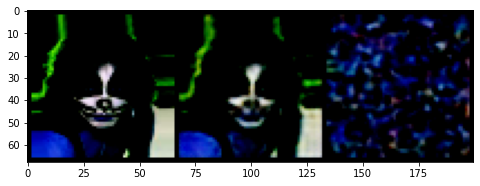

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:39<00:00:00  3.53it/s   16     0.007        0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


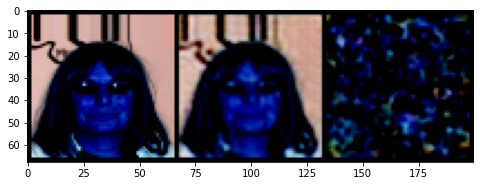

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


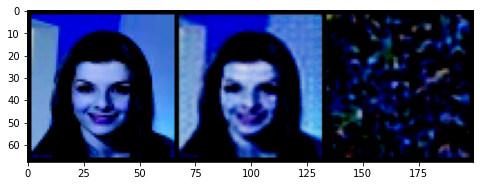

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:39<00:00:00  3.52it/s   17     0.0066       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


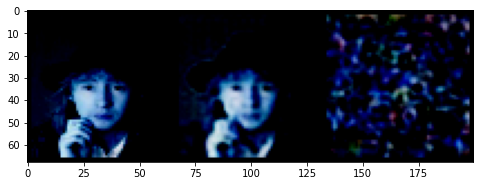

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:40<00:00:00  3.47it/s   18     0.0067      0.0001               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


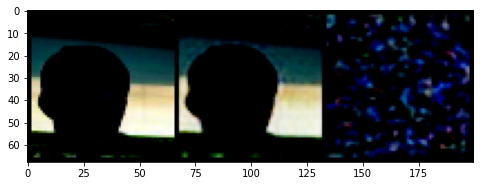

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


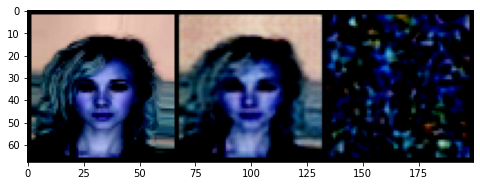

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:40<00:00:00  3.46it/s   19     0.0065      0.0002               

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


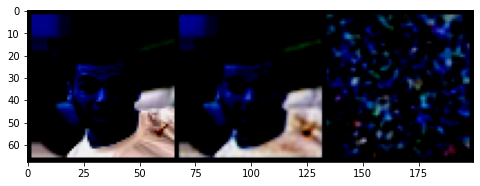

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:40<00:00:00  3.44it/s   20     0.006        0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


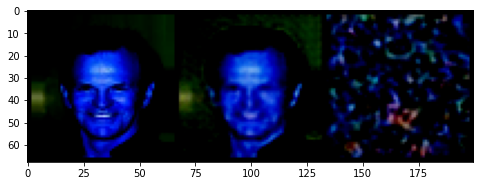

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.40it/s   21     0.006        0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


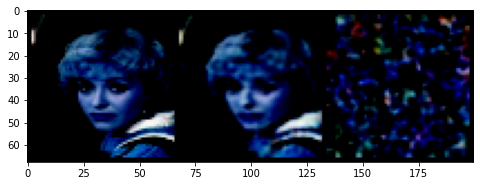

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


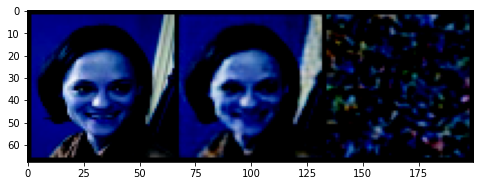

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.40it/s   22     0.006        0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


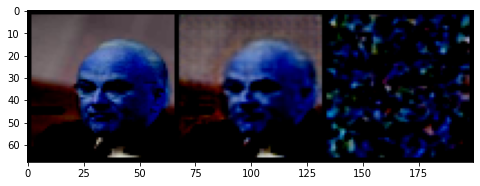

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.38it/s   23     0.0061       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


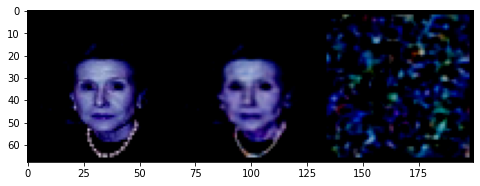

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


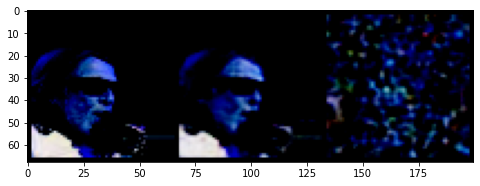

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.37it/s   24     0.0056       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


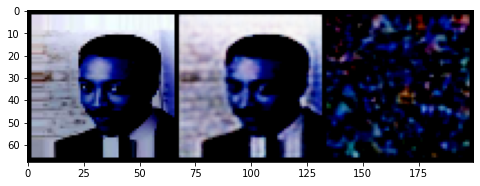

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.38it/s   25     0.0058       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


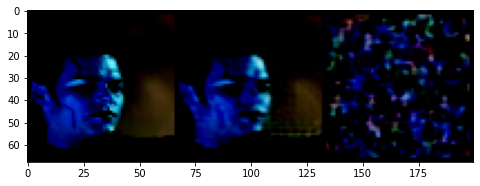

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.37it/s   26     0.0054       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


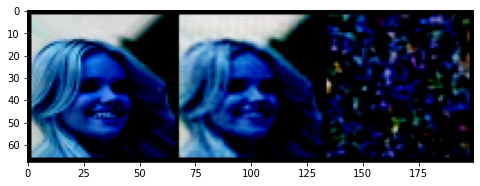

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


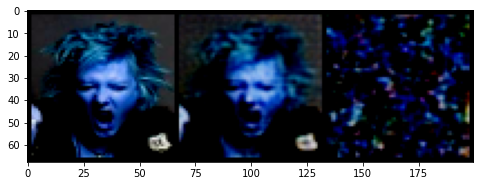

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.38it/s   27     0.0051       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


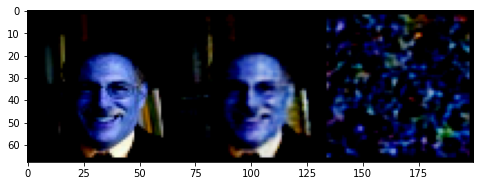

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.37it/s   28     0.0052       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


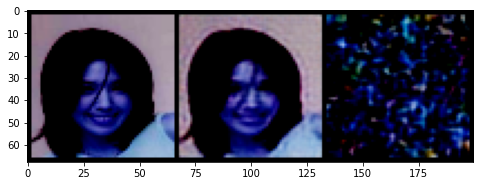

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


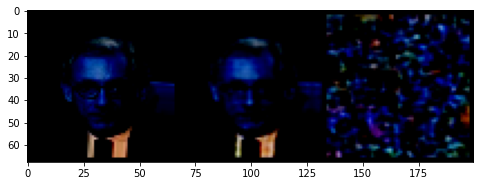

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.40it/s   29     0.0053       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


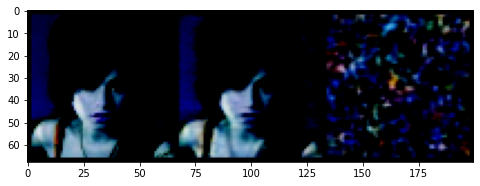

  Iters     Elapsed Time      Speed    Epoch  Loss_mse  Loss_BCELoss            
 140/140  00:00:41<00:00:00  3.38it/s   30     0.0051       0.0                 

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


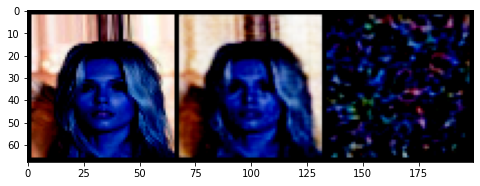

In [ ]:
enc.train()
dec.train()
c.train()
steps = 0
for epoch in range(num_epochs):
    progress_bar = qqdm(train_dataloader)

    for data in progress_bar:
      data = data.cuda()
      bs = data.size(0)
      real_label = torch.zeros((bs,1)).cuda()
      fake_label = torch.ones((bs,1)).cuda()

      enc_out = enc(data)

      u = np.random.uniform(0, 2, (bs, 48, 8, 8))   
      noise = torch.from_numpy(u).float().cuda()

      fake = dec(noise)
      real = dec(enc_out)

      # Train Classifier
      optimizer_c.zero_grad()
      f_output = c(fake)
      r_output = c(real)

      loss_f = criterion_b(f_output,fake_label)
      loss_r = criterion_b(r_output,real_label)

      loss_all = loss_f + loss_r

      loss_all.backward(retain_graph=True)

      optimizer_c.step()

      # Train dec,enc
      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()
      
      

      loss = criterion_mse(real,data)
      loss.backward()

      optimizer_enc.step()
      optimizer_dec.step()
      
      
      

      if steps % 100 == 0:
        r = randint(0,bs-1)
        recon = real[r]
        recon_fake = fake[r]
        sample = []
        sample.extend([data[r],recon,recon_fake])
        grid_img = torchvision.utils.make_grid(sample, nrow=3).cpu()

        plt.figure(figsize=(8,8))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.show()

      steps +=1

      progress_bar.set_infos({
        'Epoch': epoch+1,
        'Loss_mse': round(loss.item(), 4),
        'Loss_BCELoss': round(loss_all.item(), 4),
      })

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


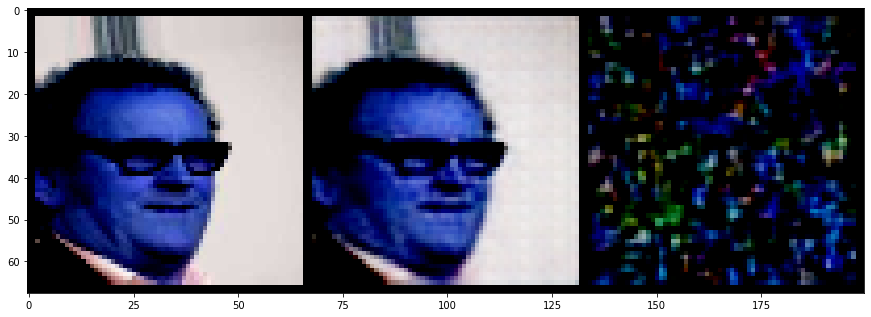

In [ ]:
r = randint(0,bs-1)
recon = real[r]
recon_fake = fake[r]
sample = []
sample.extend([data[r],recon,recon_fake])
grid_img = torchvision.utils.make_grid(sample, nrow=3).cpu()

plt.figure(figsize=(15,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [ ]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
#checkpoint_path = 'best_model_cnn.pt'
# model = torch.load(checkpoint_path)
# model.eval()
dec.eval()
enc.eval()
c.eval()
# prediction file
out_file = 'PREDICTION_FILE.csv'

In [ ]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader): 
        # if model_type in ['cnn', 'vae', 'resnet']:
        #     img = data.float().cuda()
        # elif model_type in ['fcn']:
        #     img = data.float().cuda()
        #     img = img.view(img.shape[0], -1)
        # else:
        #     img = data[0].cuda()
        img = data.cuda()
        output = dec(enc(img))

        #loss = eval_loss(output, img).sum([1, 2, 3])
        loss = c(output).view(-1)
        anomality.append(loss)

anomality = torch.cat(anomality, axis=0)

anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['Predicted'])

df.to_csv(out_file, index_label = 'Id')

# Training statistics
- Number of parameters
- Training time on colab
- Training curve of the bossbaseline model

- Simple
 - Number of parameters: 3176419
 - Training time on colab: ~ 30 min
- Medium
 - Number of parameters: 47355
 - Training time on colab: ~ 30 min
- Strong
 - Number of parameters: 47595
 - Training time on colab:  4 ~ 5 hrs
- Boss:  
 - Number of parameters: 4364140
 - Training time on colab: 1.5~3 hrs

 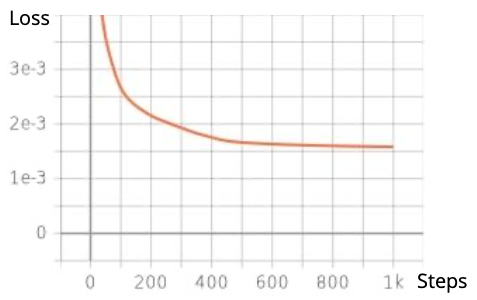
